[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/03a_BERT-classifier_PyTorch.ipynb)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# make directory 'content/10kGNAD'
if not os.path.exists('10kGNAD'):
    os.makedirs('10kGNAD')

In [ ]:
import requests

# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [ ]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])


# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("Shapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}
Shapes: (9245, 3) (1028, 3)


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 11.0 MB/s 
     |████████████████████████████████| 3.3 MB 39.0 MB/s 
     |████████████████████████████████| 61 kB 540 kB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-german-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

### Get an idea of text length and truncation

In [ ]:
# to get an idea of token length of articles (I take df_test just to save you time, should be similar in both)
token_lens = []

for txt in df_test.article:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


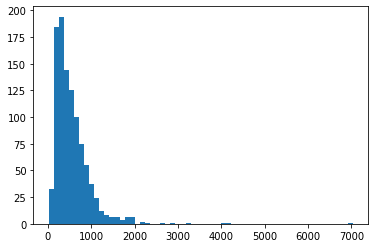

In [ ]:
plt.hist(token_lens, 60); # distribution of text length in the corpus
# --> so it WOULD definitly be better to use the "full" 512 tokens... but this takes for ever... but keep that in mind, we truncate A LOT!

### Creating Dataset and Dataloader, using the BERT tokenizer

In [ ]:
class ArticleDataset(Dataset):

  def __init__(self, content, tokenizer, max_len):
    self.content = content        # our pd.DataFrame, this could be also done with lists or other
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.content)
  
  def __getitem__(self, item):
    text = self.content.iloc[item].article
    label = self.content.iloc[item].label_id
    
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
  
    return {
      'text': text, # we don't use this, but maybe nice to keep
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label)
    }

In [ ]:
MAX_LEN = 256
ds_train = ArticleDataset(df_train, tokenizer, max_len = MAX_LEN)
ds_test = ArticleDataset(df_test, tokenizer, max_len = MAX_LEN)

In [ ]:
ds_train[0], ds_test[0] # look at one sample in Dataset

({'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'input_ids': tensor([    3,  2439, 26935,   112,   352,   519,  5483,  2294,   255, 13936,
         

In [ ]:
BATCH_SIZE = 8
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
len(dl_train), len(dl_test) # nr of batches in the DataLoaders

(1156, 129)

In [ ]:
# have a lokk at one batch in DataLoader
data = next(iter(dl_train))
print(data.keys())
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["label"].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8])


## Now: Load the pretrained BERT Model

Two possibilities
* take `BertForsequenceClassification` (already implemented BERT + dense layer on top **--> we do this here**
* take original `BertModel` and implement your own output layer --> similar to what is/was done in AI-NLP-Article-Engagement

In [ ]:
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                                      num_labels = 9)

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

### Send model to GPU

--> Be aware, in PyTorch you need to do that explicitly, in Keras you don't. Note that you have to put the data .to(device) as well, otherwise you will get errors telling you to do so.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = model.to(device)

In [ ]:
model(data["input_ids"].to(device), data["attention_mask"].to(device)) # send one batch through the (not yet trained) model, look at the output (--> logits)

SequenceClassifierOutput([('logits',
                           tensor([[-0.0834,  0.5211, -0.1348, -0.5237, -0.1024,  0.1040, -0.1452, -0.0779,
                                    -0.4180],
                                   [ 0.0530,  0.7424, -0.0222, -0.3742, -0.4455,  0.1686,  0.0412,  0.0425,
                                    -0.1948],
                                   [-0.1294,  0.3407, -0.2450, -0.3307, -0.1449,  0.2196, -0.2428, -0.0158,
                                    -0.3524],
                                   [-0.2305,  0.2761, -0.1774, -0.1918, -0.1534,  0.1230, -0.0820, -0.1518,
                                    -0.2787],
                                   [-0.1599,  0.4955, -0.2450, -0.2463, -0.2431,  0.1838, -0.0054,  0.2172,
                                    -0.5663],
                                   [-0.3765,  0.3623, -0.1580, -0.2298, -0.2570,  0.2021, -0.2414,  0.3918,
                                    -0.3352],
                                   [-0.

### Define Optimizer and Loss Fuction

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

EPOCHS = 10

## Now: The whole training loop (with evaluation inside)

##### Unlike Keras you have to implement this yourself! I know, it looks a bit confusing/overwhelming when having such a "simple" setup, but the flexibility can be very cool!

In [ ]:
history = defaultdict(list) # for saving accuracy and loss (for plotting later)

for e in range(EPOCHS):
  print(f"Epoch {e}\n----------------")
  
  ########## TRAINING ###########

  print("training...")
  model = model.train()
  losses = []
  correct_predictions = 0
  seen_samples = 0
  for n, d in enumerate(dl_train):
    print("\r---at batch nr", n, end = "")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    seen_samples += len(labels) # count all samples
    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask
                   )["logits"]
    _, preds = torch.max(outputs, dim=1) # get predicted labels from the logits (torch.max() returns tupel (max, max_indices), we want the index = label)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if n > 100: # just for time reasons, of course you wold NOT do that in real life!
      break
  
  print(f"\nCorrect predictions {correct_predictions.cpu().detach().numpy()} of {seen_samples} seen samples")
  print("So Accuracy of:", (correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  print("Mean loss:", np.mean(losses).round(4))

  history['train_acc'].append((correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  history['train_loss'].append(np.mean(losses).round(4))

  ########## EVALUATION ###########

  print("   evaluating...")
  model = model.eval()
  losses = []
  correct_predictions = 0
  seen_samples = 0
  with torch.no_grad():
    for n, d in enumerate(dl_test):
      print("\r   ---at batch nr", n, end = "")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      seen_samples += len(labels)
      outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask
                    )["logits"]
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  print(f"\n   Correct predictions {correct_predictions.cpu().detach().numpy()} of {seen_samples} seen samples")
  print("   So Accuracy of:", (correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  print("   Mean loss:", np.mean(losses).round(4))

  history['val_acc'].append((correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  history['val_loss'].append(np.mean(losses).round(4))

  

Epoch 0
----------------
training...
---at batch nr 61
Correct predictions 238 of 496 seen samples
So Accuracy of: 0.4798
Mean loss: 1.654
   evaluating...
   ---at batch nr 128
   Correct predictions 779 of 1028 seen samples
   So Accuracy of: 0.7578
   Mean loss: 0.9966
Epoch 1
----------------
training...
---at batch nr 61
Correct predictions 373 of 496 seen samples
So Accuracy of: 0.752
Mean loss: 0.8871
   evaluating...
   ---at batch nr 128
   Correct predictions 819 of 1028 seen samples
   So Accuracy of: 0.7967
   Mean loss: 0.7048
Epoch 2
----------------
training...
---at batch nr 61
Correct predictions 408 of 496 seen samples
So Accuracy of: 0.8226
Mean loss: 0.6051
   evaluating...
   ---at batch nr 128
   Correct predictions 871 of 1028 seen samples
   So Accuracy of: 0.8473
   Mean loss: 0.528
Epoch 3
----------------
training...
---at batch nr 61
Correct predictions 411 of 496 seen samples
So Accuracy of: 0.8286
Mean loss: 0.5816
   evaluating...
   ---at batch nr 128
  

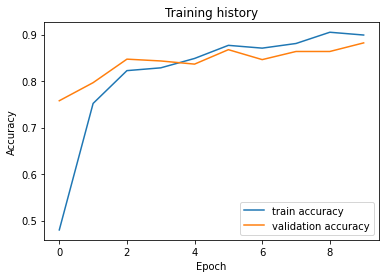

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

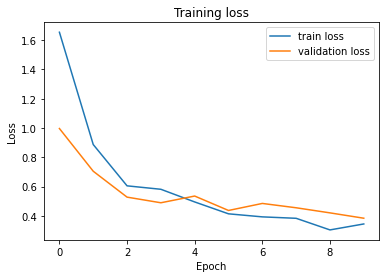

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [ ]:
#### again on test, to get classification report

In [ ]:
model = model.eval()
predictions = []
logits = []
true_labels = []
with torch.no_grad():
  for n, d in enumerate(dl_test):
    print("\r---at batch nr", n, end = "")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    outputs = model(input_ids=input_ids,
                  attention_mask=attention_mask
                  )["logits"]
    _, preds = torch.max(outputs, dim=1)
    predictions.extend(preds)
    logits.extend(outputs)
    true_labels.extend(labels)

predictions = torch.stack(predictions).cpu()
logits = torch.stack(logits).cpu()
true_labels = torch.stack(true_labels).cpu()

---at batch nr 128

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(true_labels[:15])
print(predictions[:15])
#print(logits)

tensor([4, 3, 4, 2, 2, 1, 7, 4, 5, 7, 1, 2, 1, 0, 6])
tensor([4, 4, 4, 2, 2, 1, 4, 4, 5, 7, 1, 2, 1, 4, 6])


In [ ]:
print(classification_report(true_labels, predictions, target_names=list(le.classes_)))

               precision    recall  f1-score   support

         Etat       0.93      0.76      0.84        67
       Inland       0.77      0.90      0.83       102
International       0.89      0.87      0.88       151
       Kultur       0.84      0.85      0.84        54
     Panorama       0.81      0.85      0.83       168
        Sport       0.99      1.00      1.00       120
          Web       0.97      0.93      0.95       168
   Wirtschaft       0.86      0.82      0.84       141
 Wissenschaft       0.88      0.91      0.90        57

     accuracy                           0.88      1028
    macro avg       0.88      0.88      0.88      1028
 weighted avg       0.89      0.88      0.88      1028



In [ ]:
cm = confusion_matrix(true_labels, predictions)
pd.DataFrame(cm, index = list(le.classes_), columns = list(le.classes_))

,Etat,Inland,International,Kultur,Panorama,Sport,Web,Wirtschaft,Wissenschaft
Etat,51,3,2,2,4,0,2,3,0
Inland,1,92,0,3,1,0,0,3,2
International,0,1,131,0,13,1,0,4,1
Kultur,0,1,1,46,4,0,0,0,2
Panorama,2,6,7,3,143,0,1,5,1
Sport,0,0,0,0,0,120,0,0,0
Web,1,1,4,1,1,0,157,2,1
Wirtschaft,0,13,2,0,9,0,2,115,0
Wissenschaft,0,2,0,0,2,0,0,1,52


### And again to our own texts!

In [ ]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """
]

In [ ]:
encoding = tokenizer.batch_encode_plus(
      new_texts,
      add_special_tokens=True,
      max_length=MAX_LEN,
      truncation=True,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
      )
      

In [ ]:
encoding

{'input_ids': tensor([[    3,   233,  1012,  ...,     0,     0,     0],
        [    3,   311,   128,  ...,     0,     0,     0],
        [    3, 11129,   225,  ...,     0,     0,     0],
        [    3, 18191,    88,  ...,     0,     0,     0],
        [    3,  6802, 26918,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
logits = model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))["logits"]
logits

tensor([[-0.9450, -0.2114, -0.8061, -1.0520, -0.1341,  5.0944, -0.8508, -0.9538,
         -0.9938],
        [-1.8262,  0.3280,  1.9674, -1.6808,  3.0059, -1.6918, -0.4099,  0.1330,
         -1.5873],
        [-0.6903, -0.9358, -0.8218, -0.9373, -0.7020,  5.9686, -0.1536, -1.6461,
         -0.7046],
        [ 0.1789, -0.4833, -0.7040,  4.8611,  0.3170, -0.2844, -1.2635, -0.2936,
         -0.5564],
        [ 0.0310, -0.6722, -0.8739,  4.4344,  0.7147, -0.9784, -1.2422, -0.4739,
         -0.0398]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
_, preds = torch.max(logits, dim=1)
preds.cpu().detach().numpy()

array([5, 4, 5, 3, 3])

In [ ]:
print( [ (l, id_to_label[l]) for l in preds.cpu().detach().numpy() ])

[(5, 'Sport'), (4, 'Panorama'), (5, 'Sport'), (3, 'Kultur'), (3, 'Kultur')]


## Try out Tokenizer, BertModel, ...

In [ ]:
sample = "Das ist ein Beispieltext."
sample = ""

trial = tokenizer.encode_plus(
      sample,
      add_special_tokens=True,
      max_length=20,
      truncation=True,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
trial

{'input_ids': tensor([[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
tokens = tokenizer.tokenize(sample)
print(tokens)

token_ids = tokenizer.encode(sample)
print(token_ids)

[]
[3, 4]


In [ ]:
bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
hidden_states = bert(**trial)["last_hidden_state"].squeeze() # squeeze to get rid of batch_size = 1 at the beginning

In [ ]:
hidden_states[:,:5] # here you see that [PAD] gets different representations...

tensor([[-0.6096,  0.2624, -0.3728,  0.1247, -0.1020],
        [-1.7270,  0.9448, -0.1958,  0.0825,  0.5544],
        [-0.4738, -0.0297, -0.2353,  0.3689, -0.1380],
        [-0.4727, -0.0334, -0.2510,  0.3926, -0.1339],
        [-0.3818, -0.0076, -0.2534,  0.3705, -0.1964],
        [-0.3601, -0.0960, -0.3100,  0.3609, -0.2538],
        [-0.2834, -0.1422, -0.3024,  0.3213, -0.3078],
        [-0.3131, -0.1555, -0.3254,  0.3029, -0.2953],
        [-0.3288, -0.1459, -0.3251,  0.2901, -0.3001],
        [-0.3675, -0.1161, -0.3213,  0.2995, -0.2995],
        [-0.4334, -0.0642, -0.3235,  0.3418, -0.2496],
        [-0.4730, -0.0613, -0.3377,  0.3620, -0.2462],
        [-0.5033, -0.1044, -0.3395,  0.3721, -0.2923],
        [-0.5404, -0.1043, -0.3613,  0.3904, -0.3142],
        [-0.5105, -0.1271, -0.3674,  0.3663, -0.3439],
        [-0.5114, -0.1174, -0.3773,  0.3530, -0.3182],
        [-0.5441, -0.0822, -0.3874,  0.4138, -0.2332],
        [-1.4154,  0.2531, -0.2269,  0.2884,  0.4186],
        [-